# Using STDP to classify the MNIST dataset

In [289]:
%load_ext autoreload
%autoreload 2
# basic libraries
import os
import sys
import shutil
import time
import numpy as np
import pandas as pd

# graphics libraries
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import jupyterlab_widgets as lab
from IPython.display import display
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
%config InlineBackend.figure_format='retina'
# use NMA plot style
#plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")
plt.style.use('seaborn-v0_8')
my_layout = widgets.Layout()
my_layout.width = '620px'

#machine Learning libraries
import torch
import torch.nn as nn
import snntorch as snn
import snntorch.spikeplot as splt
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


#import from my scripts
main_dir = os.getcwd()
if main_dir not in sys.path:
    print('Adding the folder for the modules')
    sys.path.append(main_dir)
import importlib

importlib.reload(importlib.import_module('neurons'))
importlib.reload(importlib.import_module('learning_rules'))
importlib.reload(importlib.import_module('plot_utils'))
importlib.reload(importlib.import_module('experiments'))
from neurons import *
from learning_rules import *
from plot_utils import *
from experiments import *


# show packages versions for python, numpy, and ipywidgets
print("Python: ", sys.version)
print("Numpy: ", np.__version__)
print("Pandas: ", pd.__version__)
print("jupyterlab_widgets: ", lab.__version__ )
print("IPywidgets: ", widgets.__version__)
print("Torch: ", torch.__version__)
print("Snntorch: ", snn.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python:  3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
Numpy:  1.26.0
Pandas:  2.1.1
jupyterlab_widgets:  3.0.9
IPywidgets:  8.0.4
Torch:  2.1.0
Snntorch:  0.6.4


# SNNTorch neurons

## Leaky Integrate-and-Fire neuron

In [280]:
# basic variables
N_pre = 10
N_post = 1
num_steps = 100

#generate input spikes
cur_in = repeat_ones(num_steps, N_pre, silent_time = 7 )
#cur_in = np.ones((num_steps, N_pre))
# convert in torch tensor
cur_in = torch.from_numpy(cur_in)


# parameters of the simulation
pars = default_pars(type_parameters='simple', 
                    w_init_value = 0.11)
beta = np.exp(-pars['dt']/pars['tau_m'])
# initialize the weights
W = weight_initializer(pars, cur_in, N_post, type_init=3)
# convert in torch tensor
W = torch.from_numpy(W)

# initialize the neuron
reset_mechanisc = 'zero' if pars['hard_reset'] else 'subtract' 
lif1 = snn.Leaky(beta=beta, threshold = pars['threshold'], 
                 learn_beta=False, 
                 learn_threshold=False, 
                 reset_mechanism=reset_mechanisc)
lif_fmp = snn.Leaky(beta=beta, threshold = 10000)

# run a simple simulation
mem = torch.zeros(1)
spk = torch.zeros(1)
mem_fmp = torch.zeros(1)
spk_fmp = torch.zeros(1)
mem_rec = []
spk_rec = []
mem_fmp_rec = []
spk_fmp_rec = []

# neuron simulation
for step in range(num_steps):
    step_cur_in = W @ cur_in[step]
    spk, mem = lif1.forward(step_cur_in, mem)
    _,mem_fmp = lif_fmp(step_cur_in, mem_fmp)
    mem_rec.append(mem)
    spk_rec.append(spk)
    mem_fmp_rec.append(mem_fmp)


# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)
mem_fmp_rec = torch.stack(mem_fmp_rec)

def plot_cur_mem_spk(cur_in, cur, mem, fmp, spk, thr_line=False, vline=False, title=False):
    # Generate Plots
    fig, ax = plt.subplots(4, figsize=(12,15), sharex=True,
                            gridspec_kw = {'height_ratios': [1, 1, 1, 0.4]})
    
    # Plot presynaptic spikes
    splt.raster(cur_in, ax = ax[0], s=400, c="tab:pink", marker="|")
    ax[0].set_ylabel("Neuron index")
    #ax[0].set_xlabel("Time step")
    if title:
        ax[0].set_title(title)

    # Plot input current
    ax[1].plot(cur, c="tab:orange")
    ax[1].set_xlim([0, num_steps])
    ax[1].set_ylabel("Input Current ($I_{in}$)")


    # Plot membrane potential
    ax[2].plot(mem)
    ax[2].plot(fmp, c="green", label="FMP")
    ax[2].set_ylabel("Membrane Potential ($U_{mem}$)")
    if thr_line:
        ax[2].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="red", linewidth=2, label = 'Thr')
    ax[2].legend(loc = 'best')
    plt.xlabel("Time step")

    # Plot output spike using spikeplot
    splt.raster(spk, ax[3], s=400, c="black", marker="|")
    if vline:
        ax[3].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
    plt.ylabel("Output spikes")
    plt.yticks([])

    plt.show()
    
plot_cur_mem_spk(cur_in, (W @ cur_in.T)[0], mem_rec, mem_fmp_rec, spk_rec, thr_line=1, title="snn.Leaky Neuron Model")


TypeError: only integer tensors of a single element can be converted to an index

## Synaptic Conductance-based LIF 

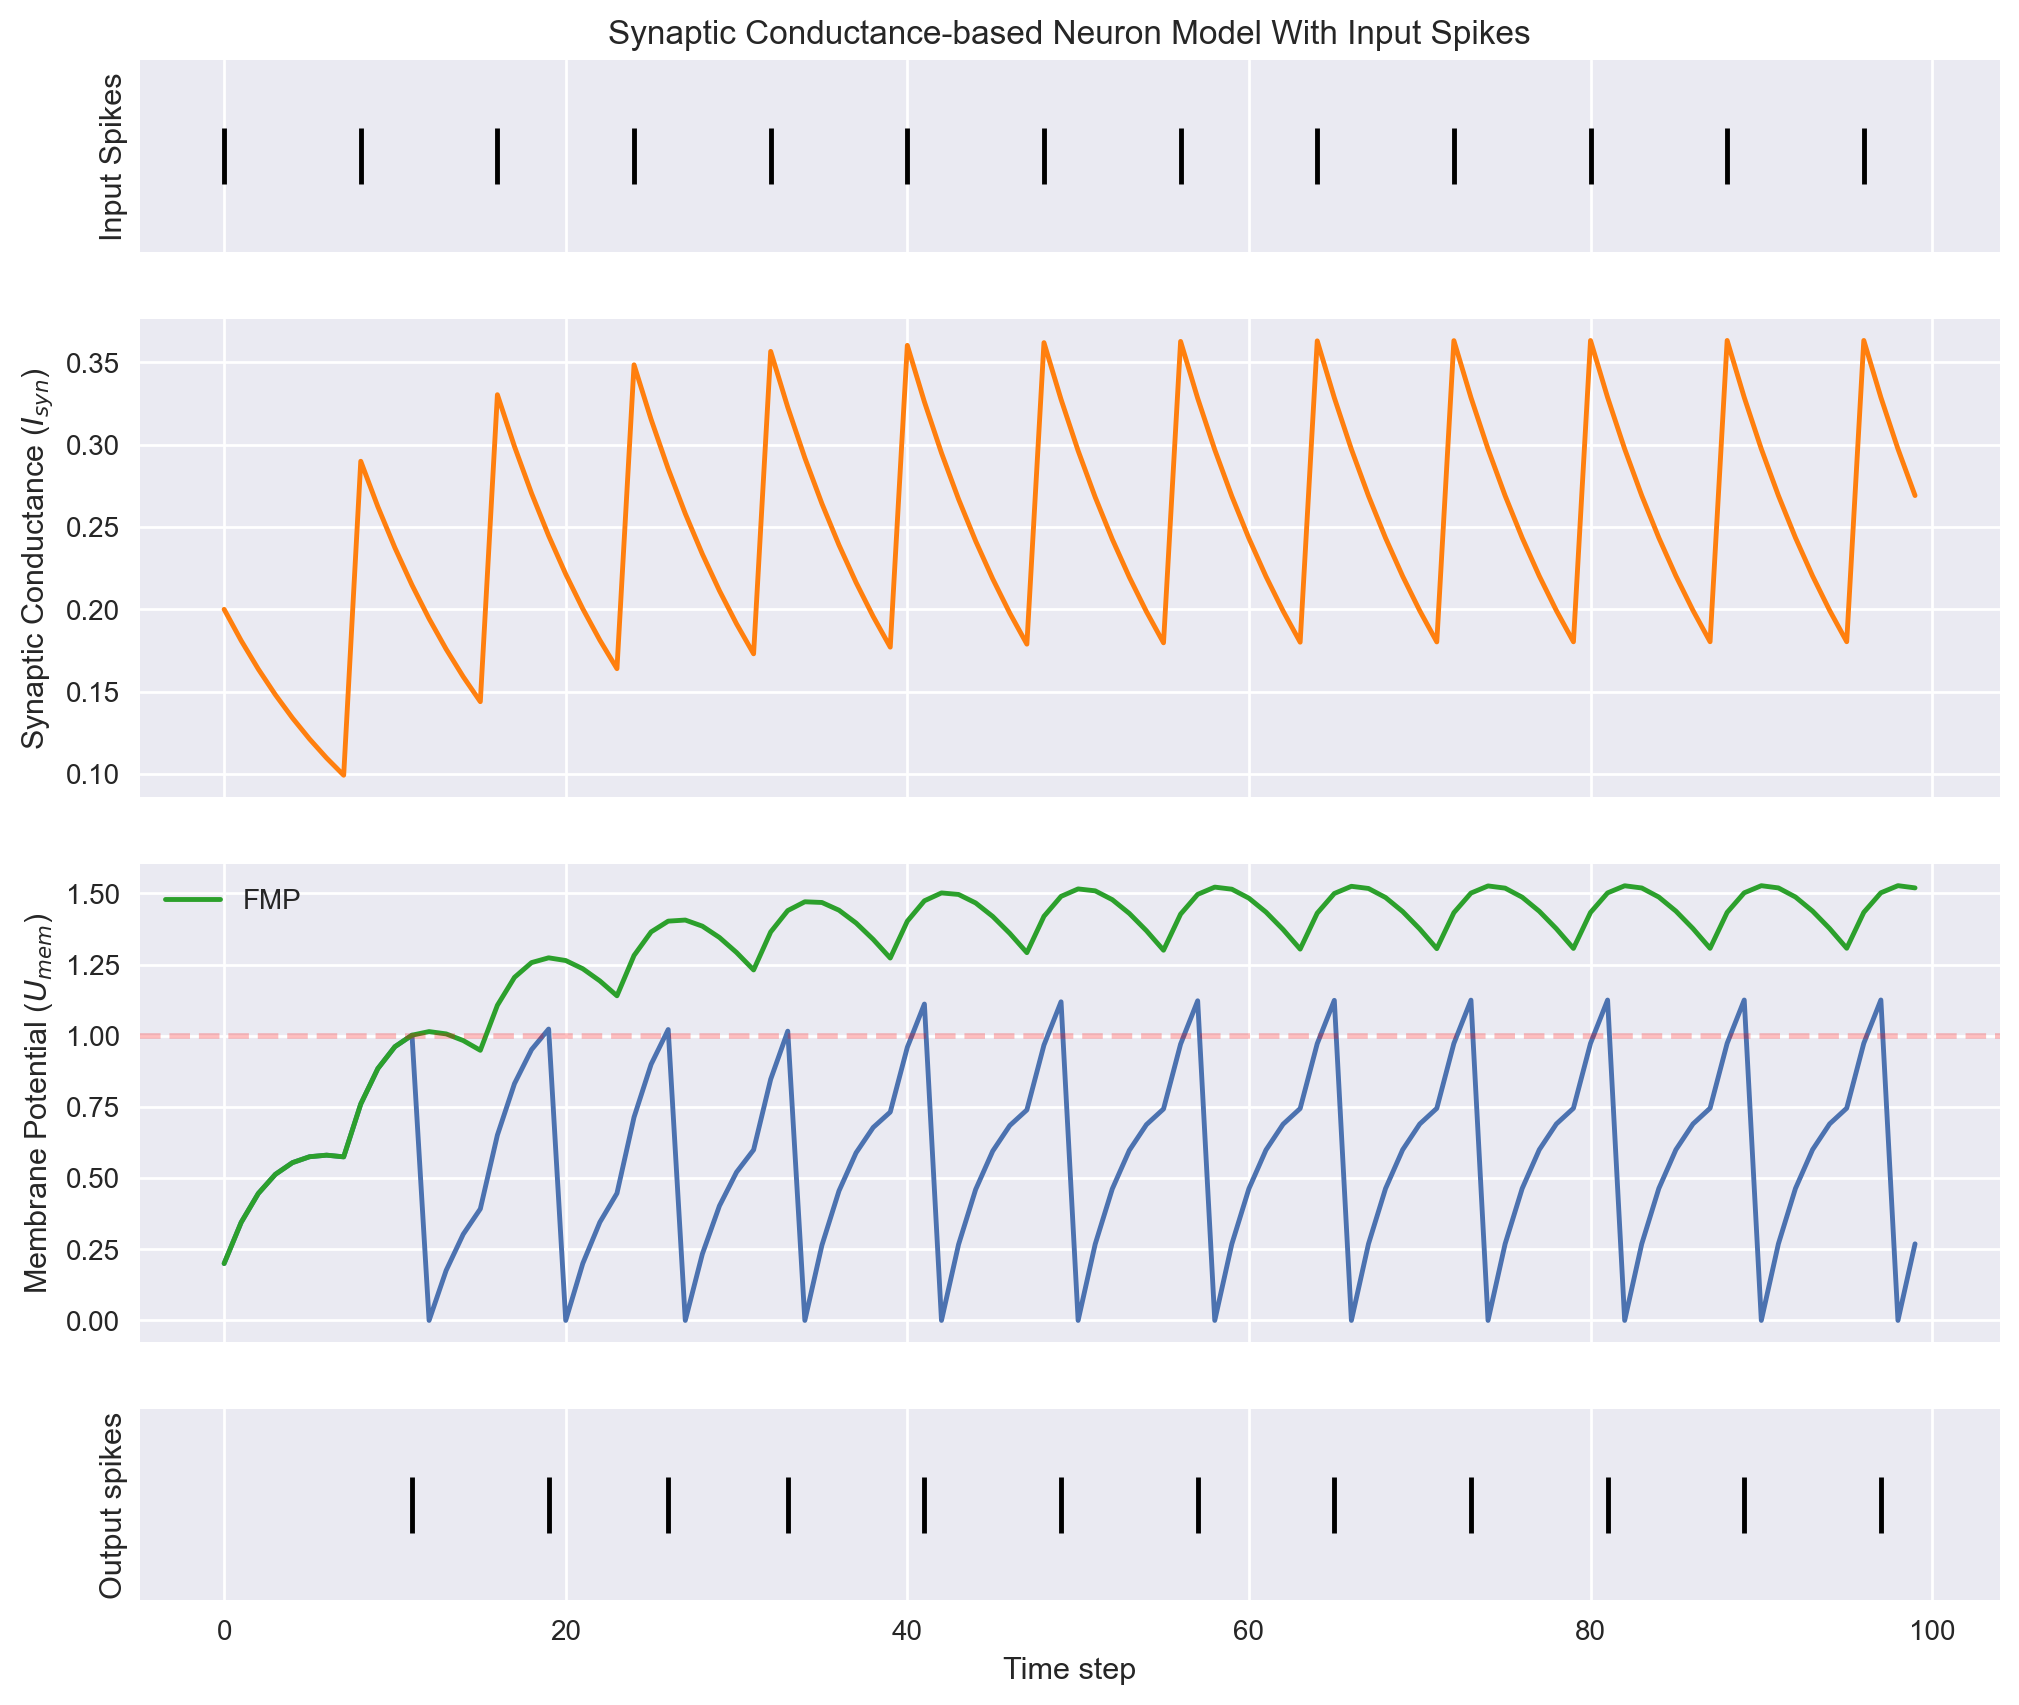

In [ ]:
#basic variables
N_pre = 10
N_post = 1
num_steps = 100

# parameters of the simulation
pars = default_pars(type_parameters='simple', 
                    w_init_value = 0.02)

# initialize the weights
W = weight_initializer(pars, cur_in, N_post, type_init=3)
W = torch.from_numpy(W)

#generate input spikes
rate=0.3
#cur_in = Poisson_generator(pars['dt'],rate, N_pre,num_steps)
#cur_in = np.ones((num_steps, N_pre))
cur_in = repeat_ones(num_steps, N_pre, silent_time = 8 )
cur_in = torch.from_numpy(cur_in)

# Temporal dynamics to compute on the basis of params
alpha = np.exp(-pars['dt']/pars['tau_syn_exc'])  # on SNN Torch tutorial this was 0.9 and I found 0.904
beta = np.exp(-pars['dt']/pars['tau_m'] * (1+pars['max_g']))  # on SNN Torch tutorial this was 0.8 and I found 0.8187

# Initialize 2nd-order LIF neuron
reset_mechanism = 'zero' if pars['hard_reset'] else 'subtract'
lif2 = snn.Synaptic(alpha=alpha, beta=beta,threshold = pars['threshold'],
                    learn_alpha=False, 
                    learn_beta=False, 
                    learn_threshold=False, 
                    reset_mechanism=reset_mechanism)
lif2_fmp = snn.Synaptic(alpha=alpha, beta=beta, threshold=100000 ) # second neuron with no threshold to visualize the FMP


# Initialize hidden states and output
syn, mem = lif1.init_synaptic() # random initialization of synapse and membrane
syn_fmp, mem_fmp = lif_fmp.init_synaptic() # random initialization of synapse and membrane
syn_rec = []
mem_rec = []
spk_rec = []
mem_fmp_rec = []
syn_fmp_rec = []

# Simulate neurons
for step in range(num_steps):
    step_cur_in = W @ cur_in[step]
    spk_out, syn, mem = lif2(step_cur_in, syn, mem)
    _, syn_fmp, mem_fmp = lif2_fmp(step_cur_in, syn_fmp, mem_fmp)
    spk_rec.append(spk_out)
    syn_rec.append(syn)
    mem_rec.append(mem)
    mem_fmp_rec.append(mem_fmp)


# convert lists to tensors
spk_rec = torch.stack(spk_rec)
syn_rec = torch.stack(syn_rec)
mem_rec = torch.stack(mem_rec)
mem_fmp_rec = torch.stack(mem_fmp_rec)

def plot_spk_cur_mem_spk(spk_in, syn_rec, mem_rec, mem_fmp_rec, spk_rec, title):
    # Generate Plots
    fig, ax = plt.subplots(4, figsize=(12,10), sharex=True,
                            gridspec_kw = {'height_ratios': [0.4, 1, 1, 0.4]})

    # Plot input current
    splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
    ax[0].set_ylabel("Input Spikes")
    ax[0].set_title("Synaptic Conductance-based Neuron Model With Input Spikes")
    ax[0].set_yticks([])

    # Plot membrane potential
    ax[1].plot(syn_rec.detach().numpy(), c="tab:orange")
    ax[1].set_ylabel("Synaptic Conductance ($I_{syn}$)")
    plt.xlabel("Time step")

    # Plot membrane potential
    ax[2].plot(mem_rec.detach().numpy())
    ax[2].plot(mem_fmp_rec.detach().numpy(), c="tab:green", label="FMP")
    ax[2].set_ylabel("Membrane Potential ($U_{mem}$)")
    ax[2].axhline(y=1, alpha=0.25, linestyle="dashed", c="red", linewidth=2)
    ax[2].legend(loc = 'best')
    plt.xlabel("Time step")

    # Plot output spike using spikeplot
    splt.raster(spk_rec, ax[3], s=400, c="black", marker="|")
    plt.ylabel("Output spikes")
    ax[3].set_yticks([])

    plt.show()

plot_spk_cur_mem_spk((W @ cur_in.T)[0], syn_rec, mem_rec, mem_fmp_rec, spk_rec, title="snn.Synaptic Neuron Model")

# STDP preliminaries experiments

## LIF

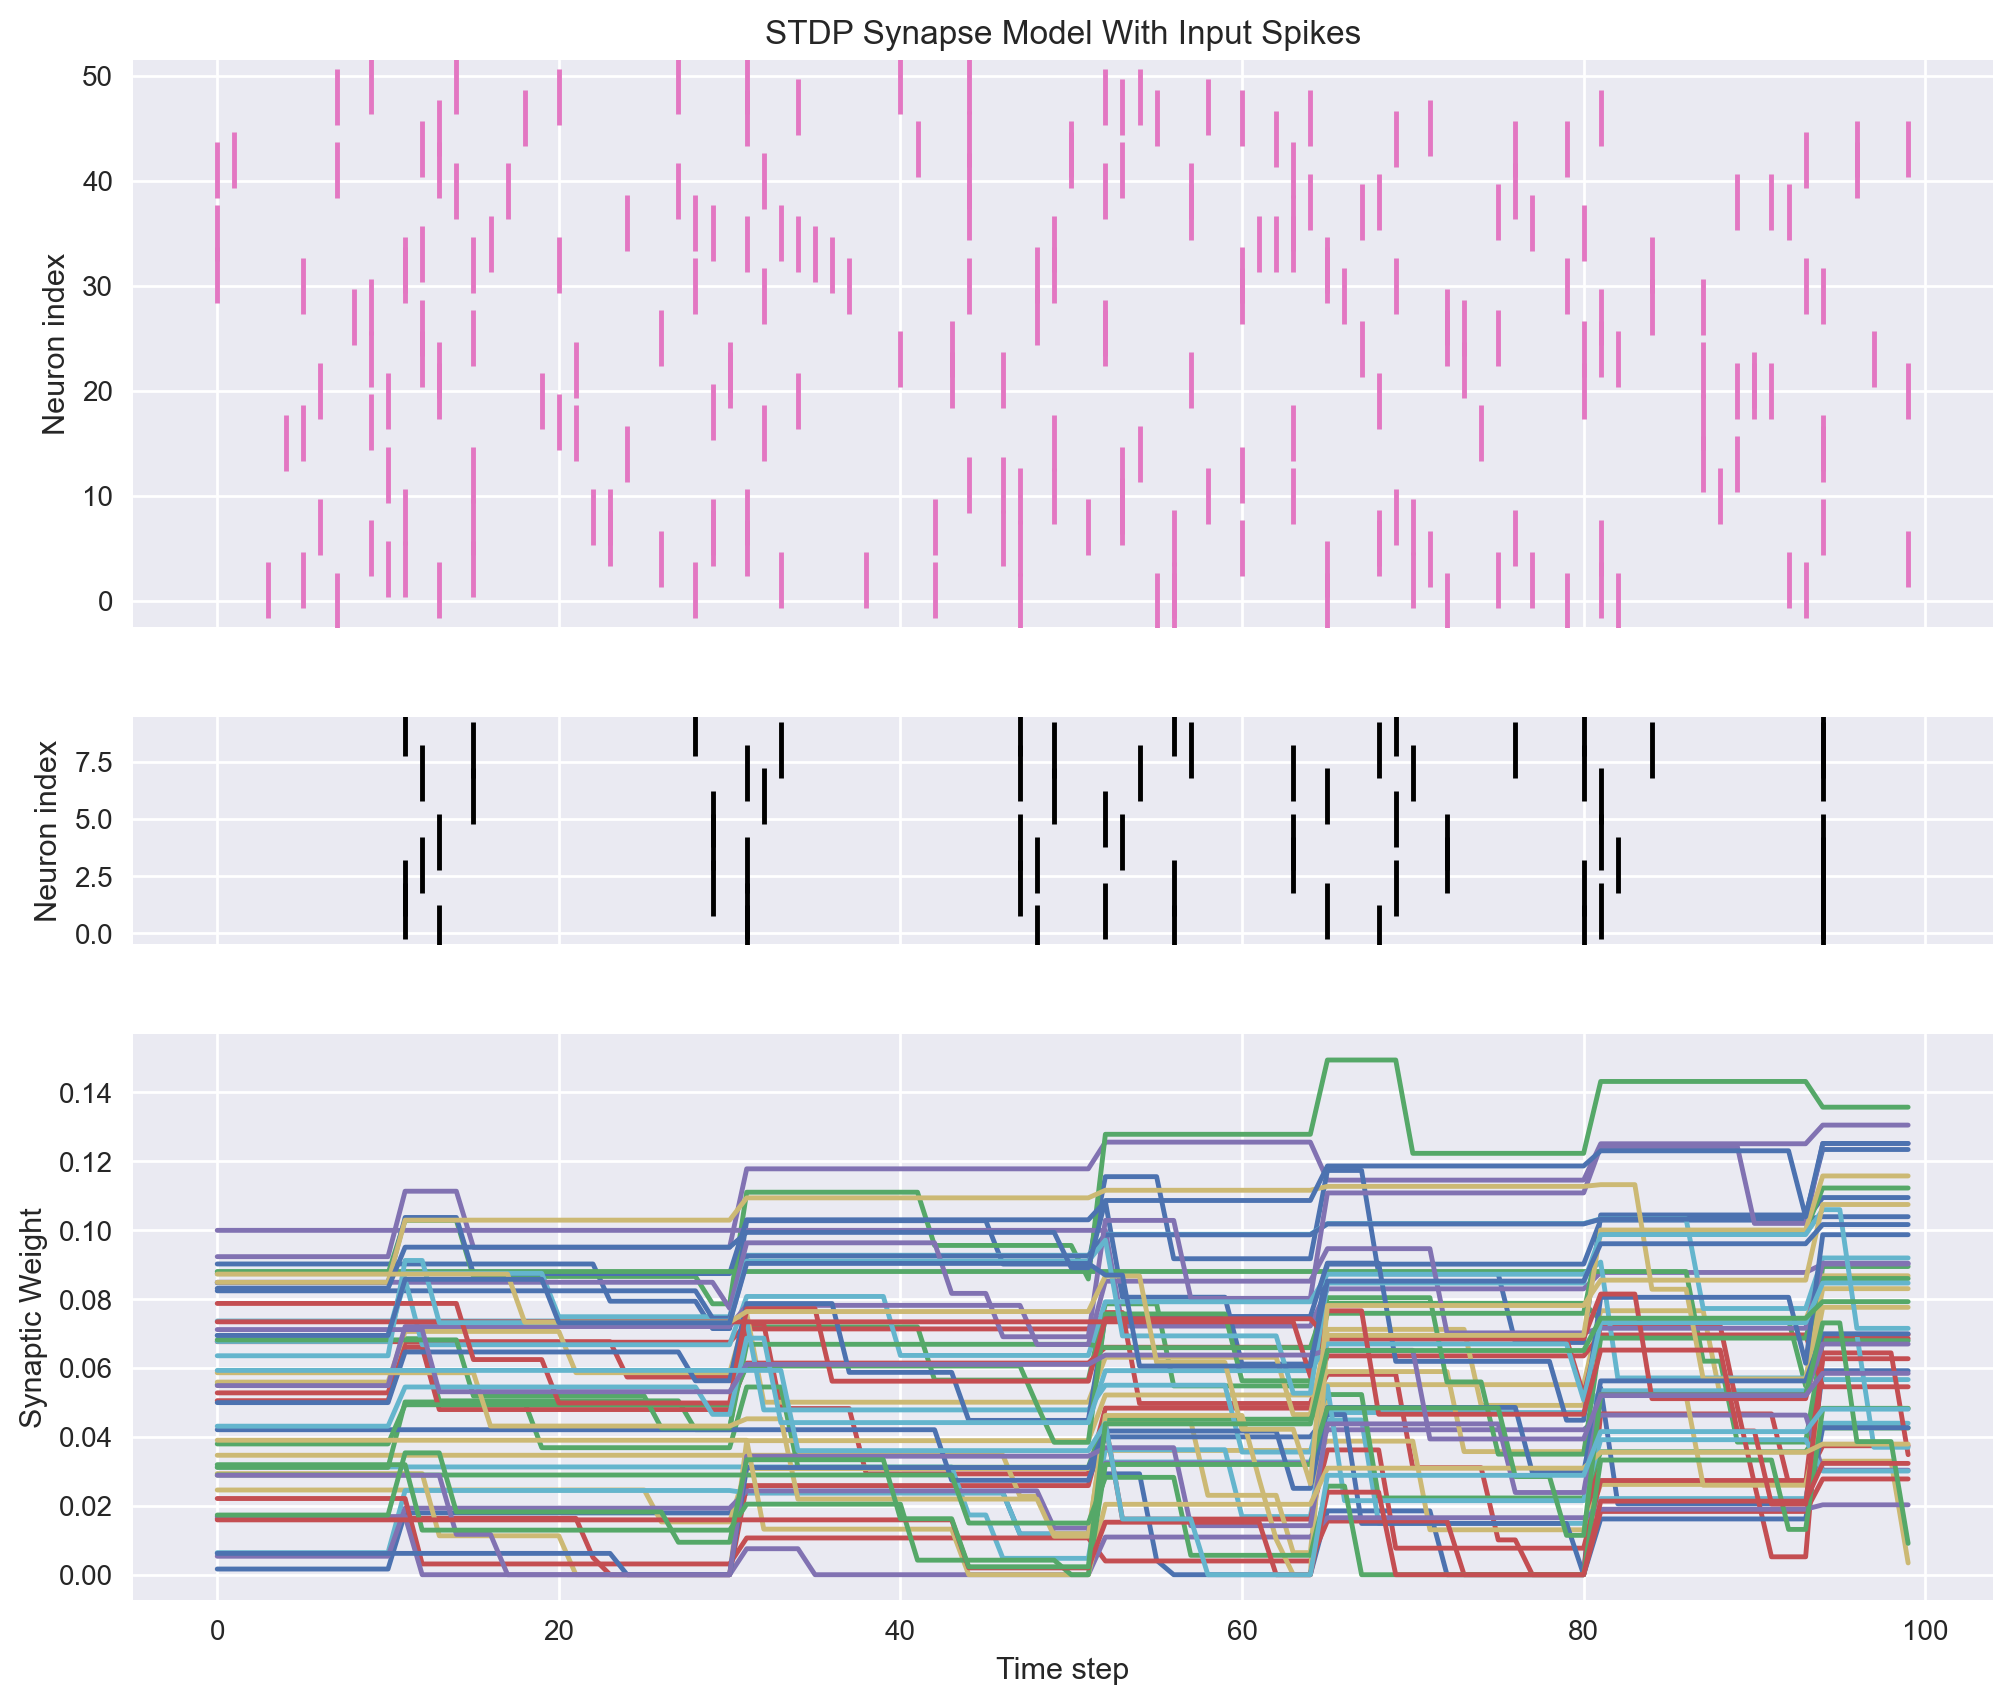

In [ ]:
# basic variables
N_pre = 50
N_post = 10
num_steps = 100

# parameters of the simulation
pars = default_pars(type_parameters='simple', 
                    w_init_value = 0.1)
time_steps = np.arange(num_steps) * pars['dt']
rate = 0.05

#generate input spikes
#cur_in = repeat_ones(num_steps, N_pre, silent_time = 8 )
cur_in = Poisson_generator(pars['dt'], rate, N_pre, num_steps)
cur_in = torch.from_numpy(cur_in)

# initialize the weights
W = weight_initializer(pars, cur_in, N_post, type_init=3) * np.random.rand(N_post,N_pre) # noise added to appreciate different STDP dynamics
W = torch.from_numpy(W)

# initialize postsynaptic neurons
beta = np.exp(-pars['dt']/pars['tau_m'])
rm = 'zero' if pars['hard_reset'] else 'subtract' 
thr = pars['threshold']
post_neurons = [ snn.Leaky(beta = beta, threshold=thr, reset_mechanism=rm) for _ in range(N_post)]

# initialize the tracking variables
mem_record = np.zeros((num_steps+1, N_post))
spk_record = np.zeros((num_steps+1, N_post))
mem_record[0,:] = np.asarray([0 for i in range(N_post)])
spk_record[0,:] = np.asarray([0 for i in range(N_post)])

# intialize the synapses
my_synapses = STDP_synapse(pars, N_pre, N_post, W_init = W ) # this works even if now W is a tensor!

# run the simulation
for step in range(num_steps):
    # current injected at this time step
    pre_syn_spikes = cur_in[step]
    cur_in_step = W @ pre_syn_spikes

    #spike generated by the layer
    for i in range(N_post):
        spk_record[step+1,i],mem_record[step+1,i] = post_neurons[i](cur_in_step[i], mem_record[step,i])

    post_syn_spk = spk_record[step+1,:]
    
    # update the weights
    my_synapses.update_weights([pre_syn_spikes.detach().numpy(),post_syn_spk])
    W = my_synapses.W

# convert the results to torch tensors
mem_record = torch.from_numpy(mem_record[1:,:])
spk_record = torch.from_numpy(spk_record[1:,:])

# plot the results
fig, ax = plt.subplots(3, figsize=(12,10), sharex=True, gridspec_kw = {'height_ratios': [1, 0.4, 1]})

# raster plot of the input spikes
splt.raster(cur_in, ax = ax[0], s=400, c="tab:pink", marker="|")
ax[0].set_ylabel("Neuron index")
ax[0].set_title("STDP Synapse Model With Input Spikes")

# raster plot of the output spikes
splt.raster(spk_record, ax = ax[1], s=400, c="black", marker="|")
ax[1].set_ylabel("Neuron index")

# plot of the weights evolution
weight_history = my_synapses.get_records()['W'][1:,1,:]
ax[2].plot(time_steps, weight_history)
ax[2].set_ylabel("Synaptic Weight")
ax[2].set_xlabel("Time step")

plt.show()

## Conductance-based LIF

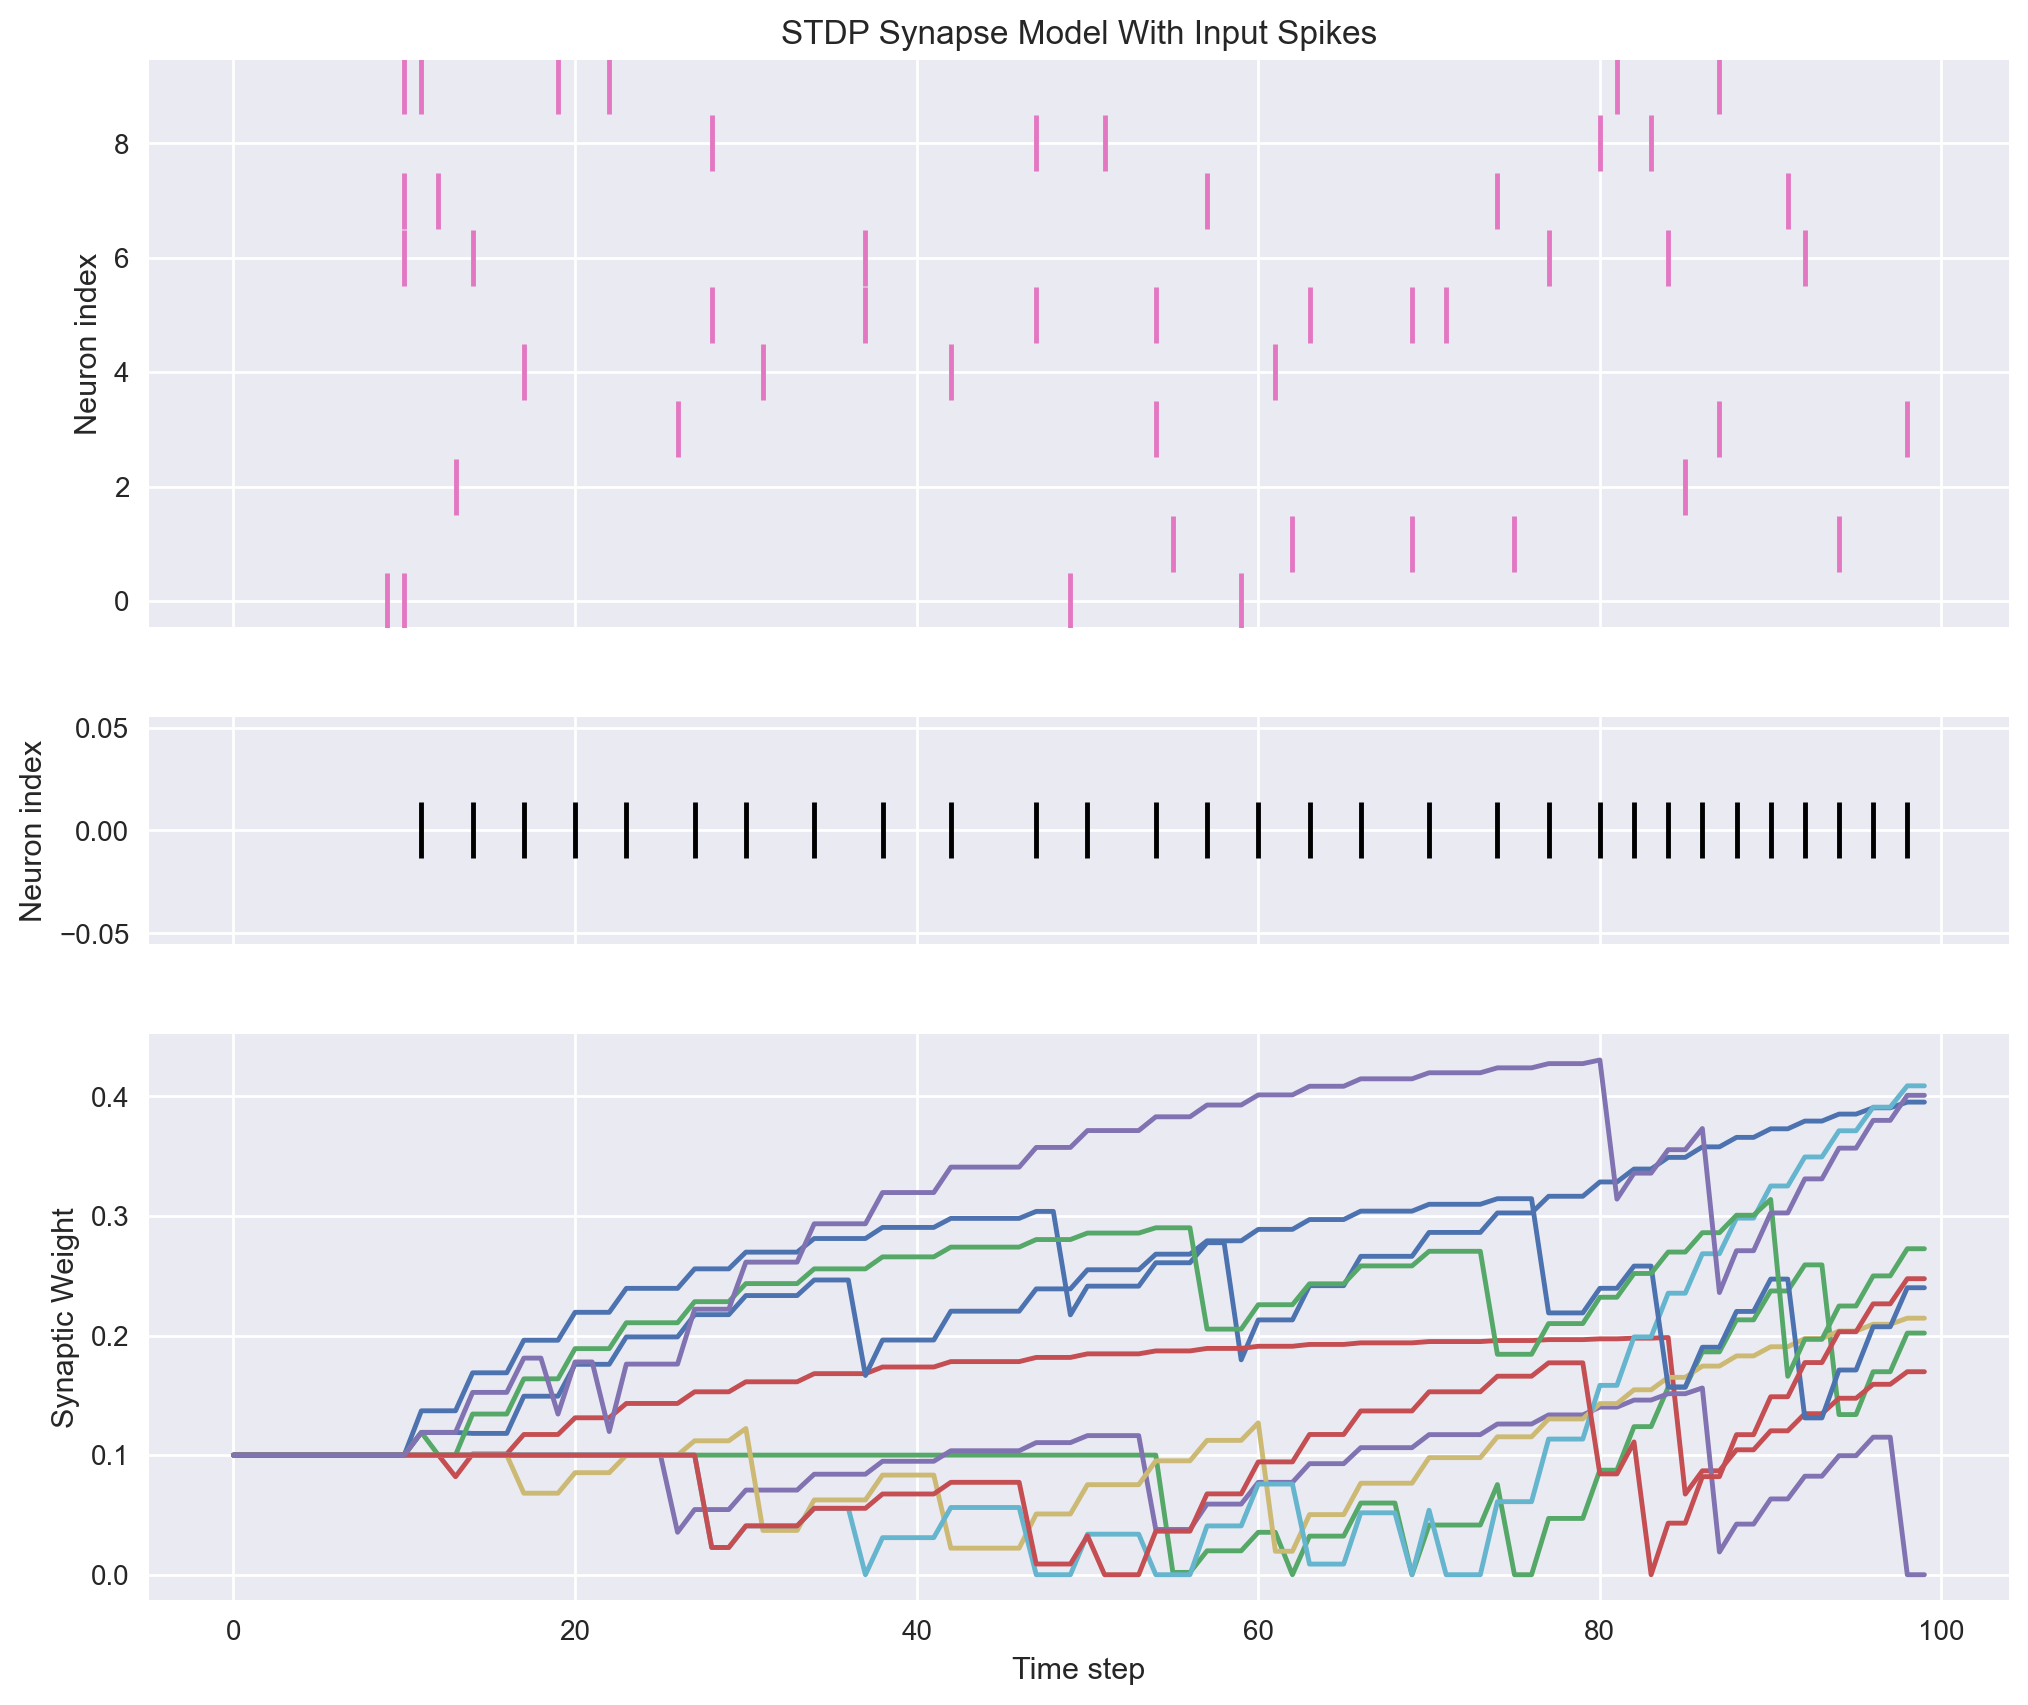

'# plot the synaptic traces and conductance current\nfig, ax = plt.subplots(2, figsize=(12,10), sharex=True, gridspec_kw = {\'height_ratios\': [ 1, 1]})\npre_syn_trace = my_synapses.get_records()[\'pre_trace\'][:,0]\n\nax[0].plot(time_steps, pre_syn_trace)\nax[0].set_ylabel("Pre-synaptic trace")\nax[0].set_title("Synaptic Trace and Conductance Current")\n\nax[1].plot(time_steps, cond_record[1:,0])\nax[1].set_ylabel("Conductance current")\nax[1].set_xlabel("Time step")'

In [ ]:
# basic variables
N_pre = 10
N_post = 1
num_steps = 100

# parameters of the simulation
pars = default_pars(type_parameters='simple', 
                    w_init_value = 0.1)
time_steps = np.arange(num_steps) * pars['dt']
rate = 0.05

#generate input spikes
#cur_in = repeat_ones(num_steps, N_pre, silent_time = 8 )
cur_in = Poisson_generator(pars['dt'], rate, N_pre, num_steps)
cur_in = torch.from_numpy(cur_in)

# initialize the weights
W = weight_initializer(pars, cur_in, N_post, type_init=3) #* np.random.rand(N_post,N_pre) # noise added to appreciate different STDP dynamics
W = torch.from_numpy(W)

# initialize postsynaptic neurons
beta = np.exp(-pars['dt']/pars['tau_m'] *(1+pars['max_g']))
alpha = np.exp(-pars['dt']/pars['tau_syn_exc'])
rm = 'zero' if pars['hard_reset'] else 'subtract' 
thr = pars['threshold']
post_neurons = [ snn.Synaptic(alpha = alpha, beta = beta, threshold=thr, reset_mechanism=rm) for _ in range(N_post)]

# initialize the tracking variables
mem_record = np.zeros((num_steps+1, N_post))
spk_record = np.zeros((num_steps+1, N_post))
cond_record = np.zeros((num_steps+1, N_post))
mem_record[0,:] = np.asarray([0 for i in range(N_post)])
spk_record[0,:] = np.asarray([0 for i in range(N_post)])
cond_record[0,:] = np.asarray([0 for i in range(N_post)])

# intialize the synapses
my_synapses = STDP_synapse(pars, N_pre, N_post, W_init = W ) # this works even if now W is a tensor!

# run the simulation
for step in range(num_steps):
    # current injected at this time step
    pre_syn_spikes = cur_in[step]
    cur_in_step = W @ pre_syn_spikes

    #spike generated by the layer
    for i in range(N_post):
        spk, cond, mem = post_neurons[i](cur_in_step[i], cond_record[step, i], mem_record[step,i])
        spk_record[step+1,i] = spk
        mem_record[step+1,i] = mem
        cond_record[step+1,i] = cond

    post_syn_spk = spk_record[step+1,:]
    
    # update the weights
    my_synapses.update_weights([pre_syn_spikes.detach().numpy(),post_syn_spk])
    W = my_synapses.W

# convert the results to torch tensors
mem_record = torch.from_numpy(mem_record[1:,:])
spk_record = torch.from_numpy(spk_record[1:,:])

# plot the results
fig, ax = plt.subplots(3, figsize=(12,10), sharex=True, gridspec_kw = {'height_ratios': [1, 0.4, 1]})

# raster plot of the input spikes
splt.raster(cur_in, ax = ax[0], s=400, c="tab:pink", marker="|")
ax[0].set_ylabel("Neuron index")
ax[0].set_title("STDP Synapse Model With Input Spikes")

# raster plot of the output spikes
splt.raster(spk_record, ax = ax[1], s=400, c="black", marker="|")
ax[1].set_ylabel("Neuron index")

# plot of the weights evolution
weight_history = my_synapses.get_records()['W'][1:,0,:]
ax[2].plot(time_steps, weight_history)
ax[2].set_ylabel("Synaptic Weight")
ax[2].set_xlabel("Time step")

plt.show()

"""# plot the synaptic traces and conductance current
fig, ax = plt.subplots(2, figsize=(12,10), sharex=True, gridspec_kw = {'height_ratios': [ 1, 1]})
pre_syn_trace = my_synapses.get_records()['pre_trace'][:,0]

ax[0].plot(time_steps, pre_syn_trace)
ax[0].set_ylabel("Pre-synaptic trace")
ax[0].set_title("Synaptic Trace and Conductance Current")

ax[1].plot(time_steps, cond_record[1:,0])
ax[1].set_ylabel("Conductance current")
ax[1].set_xlabel("Time step")"""


## Spotting correlated input

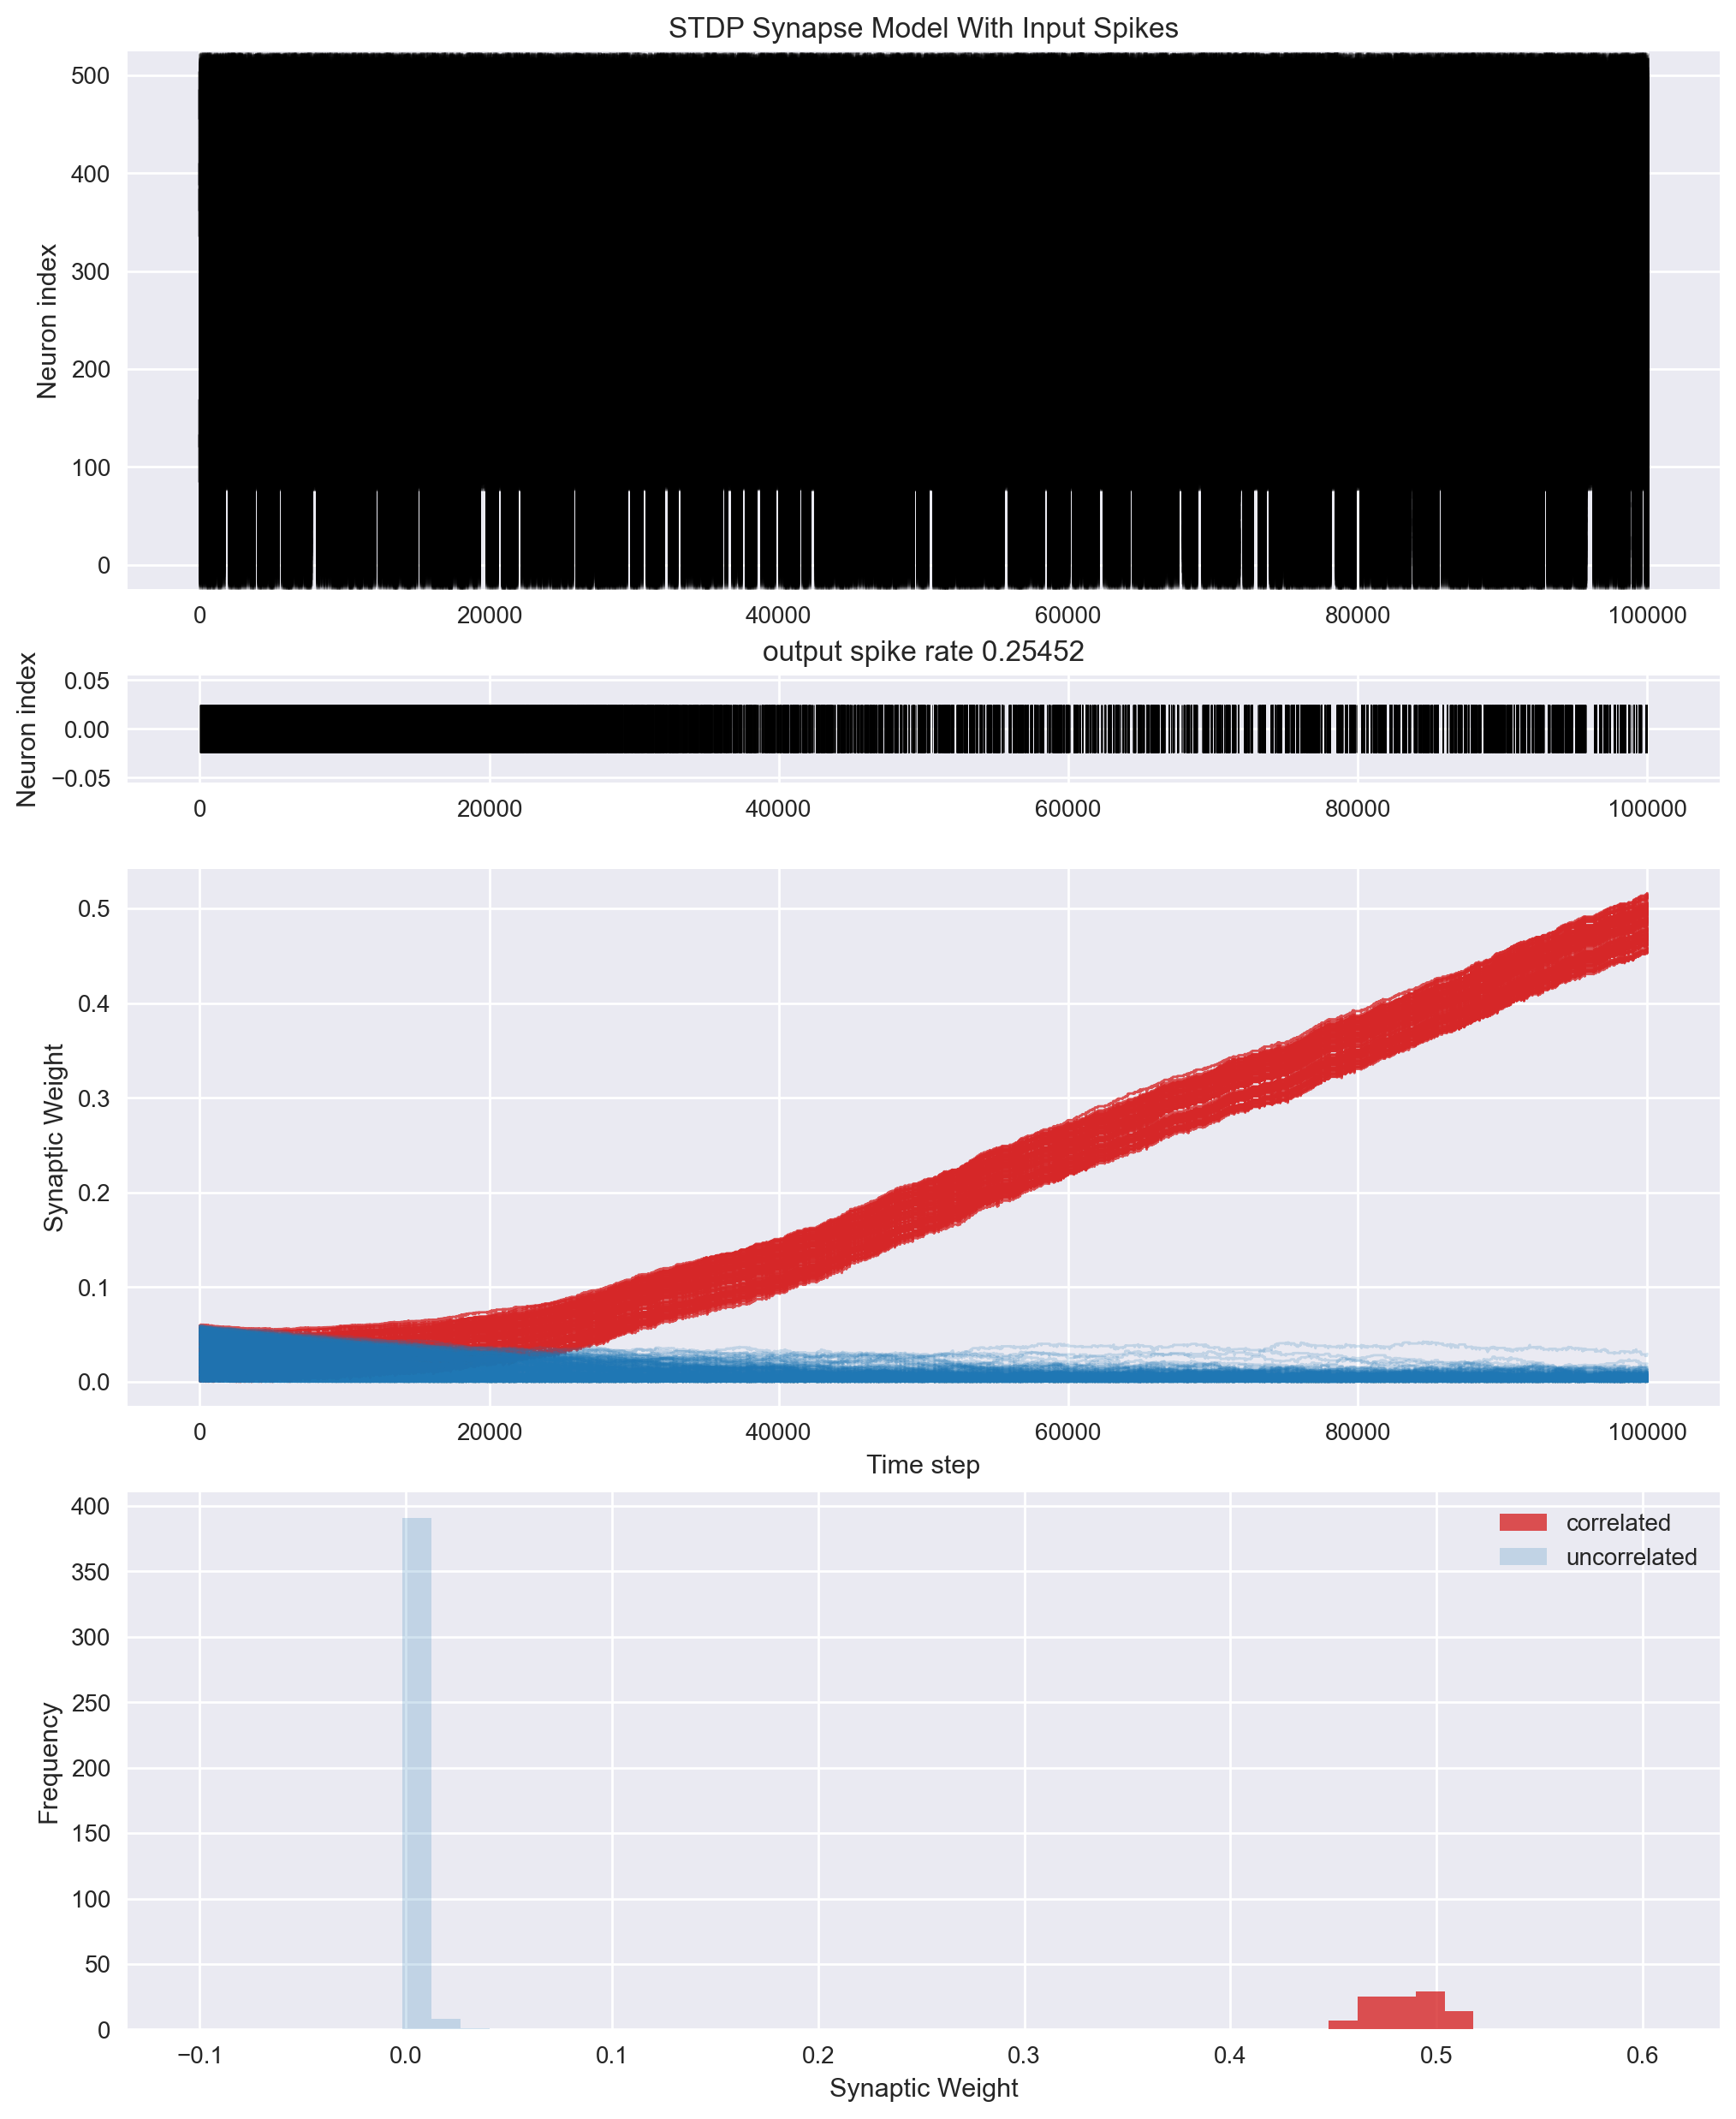

In [ ]:
# basic variables
N_pre = 500
N_pre_correlated = 100
N_post = 1
num_steps = 100000

# parameters of the simulation
pars = default_pars(type_parameters='simple', 
                    w_init_value = 0.1,
                    A_minus = 0.0088 * 0.024,
                    A_plus = 0.008 * 0.024,)
dt = pars['dt']
time_steps = np.arange(num_steps) * dt
rate = 0.01

# generate the injected spikes with some correlation
cur_in_numpy,_ = random_shifted_trains(dt, num_steps, N_pre, N_pre_correlated , rate = rate)
cur_in = torch.from_numpy(cur_in_numpy)

# initialize the weights
W = np.random.rand(N_post, N_pre) * pars['w_init_value'] / 100
W = weight_initializer(pars, cur_in_numpy, N_post, type_init=2) * pars['w_init_value']  #* np.random.rand(N_post,N_pre) # noise added to appreciate different STDP dynamics
W = torch.from_numpy(W)

# initialize postsynaptic neurons
beta = np.exp(-pars['dt']/pars['tau_m'] *(1+pars['max_g'])) # or 0.8
alpha = np.exp(-pars['dt']/pars['tau_syn_exc']) #or 0.9
rm = 'zero' if pars['hard_reset'] else 'subtract' 
thr = pars['threshold']
post_neurons = [ snn.Synaptic(alpha = alpha, beta = beta, threshold=thr, reset_mechanism=rm) for _ in range(N_post)]

# initialize the tracking variables
mem_record = np.zeros((num_steps+1, N_post))
spk_record = np.zeros((num_steps+1, N_post))
cond_record = np.zeros((num_steps+1, N_post))
mem_record[0,:] = np.asarray([0 for i in range(N_post)])
spk_record[0,:] = np.asarray([0 for i in range(N_post)])
cond_record[0,:] = np.asarray([0 for i in range(N_post)])

# intialize the synapses
my_synapses = STDP_synapse(pars, N_pre, N_post, W_init = W ) # this works even if now W is a tensor!

# run the simulation
for step in range(num_steps):
    # current injected at this time step
    pre_syn_spikes = cur_in[step]
    cur_in_step = W @ pre_syn_spikes

    #spike generated by the layer
    for i in range(N_post):
        spk, cond, mem = post_neurons[i](cur_in_step[i], cond_record[step, i], mem_record[step,i])
        spk_record[step+1,i] = spk
        mem_record[step+1,i] = mem
        cond_record[step+1,i] = cond

    post_syn_spk = spk_record[step+1,:]
    
    # update the weights
    my_synapses.update_weights([pre_syn_spikes.detach().numpy(),post_syn_spk])
    W = my_synapses.W

# convert the results to torch tensors
mem_record = torch.from_numpy(mem_record[1:,:])
spk_record = torch.from_numpy(spk_record[1:,:])

# plot the input and output raster plots, the weights evolution and the final weights distribution
weight_history = my_synapses.get_records()['W'][1:,0,:]
fig, ax = plt.subplots(4, figsize=(12,15), gridspec_kw = {'height_ratios': [1, 0.2, 1, 1]})

# raster plot of the input spikes
splt.raster(cur_in, ax = ax[0], s=400, c="black", marker="|", alpha = 0.3)
ax[0].set_ylabel("Neuron index")
ax[0].set_title("STDP Synapse Model With Input Spikes")

# raster plot of the output spikes
splt.raster(spk_record, ax = ax[1], s=400, c="black", marker="|", alpha = 0.8, lw = 0.3)
ax[1].set_ylabel("Neuron index")
ax[1].set_title(f'output spike rate {spk_record.mean()}')

# plot of the weights evolution
cor_weights = pd.DataFrame(weight_history[:, :N_pre_correlated])
uncor_weights = pd.DataFrame(weight_history[:, N_pre_correlated:])
cor_weights.plot(ax = ax[2], legend = False, color = 'tab:red', alpha = 0.8, lw = 1.)
uncor_weights.plot(ax = ax[2], legend = False, color = 'tab:blue', alpha = 0.2, lw = 1.)
ax[2].set_ylabel("Synaptic Weight")
ax[2].set_xlabel("Time step")

# plot the final weights distribution
time_step = -1
w_min = np.min(weight_history[time_step,:])-0.1
w_max = np.max(weight_history[time_step,:])+0.1
width = (w_max - w_min)/51
bins = np.arange(w_min, w_max, width)
ax[3].hist(weight_history[time_step,:N_pre_correlated], bins = bins, color = 'tab:red', alpha = 0.8, label = 'correlated')
ax[3].hist(weight_history[time_step,N_pre_correlated:], bins = bins, color = 'tab:blue', alpha = 0.2, label = 'uncorrelated')
ax[3].set_xlabel("Synaptic Weight")
ax[3].set_ylabel("Frequency")
ax[3].legend(loc = 'best')

plt.show()



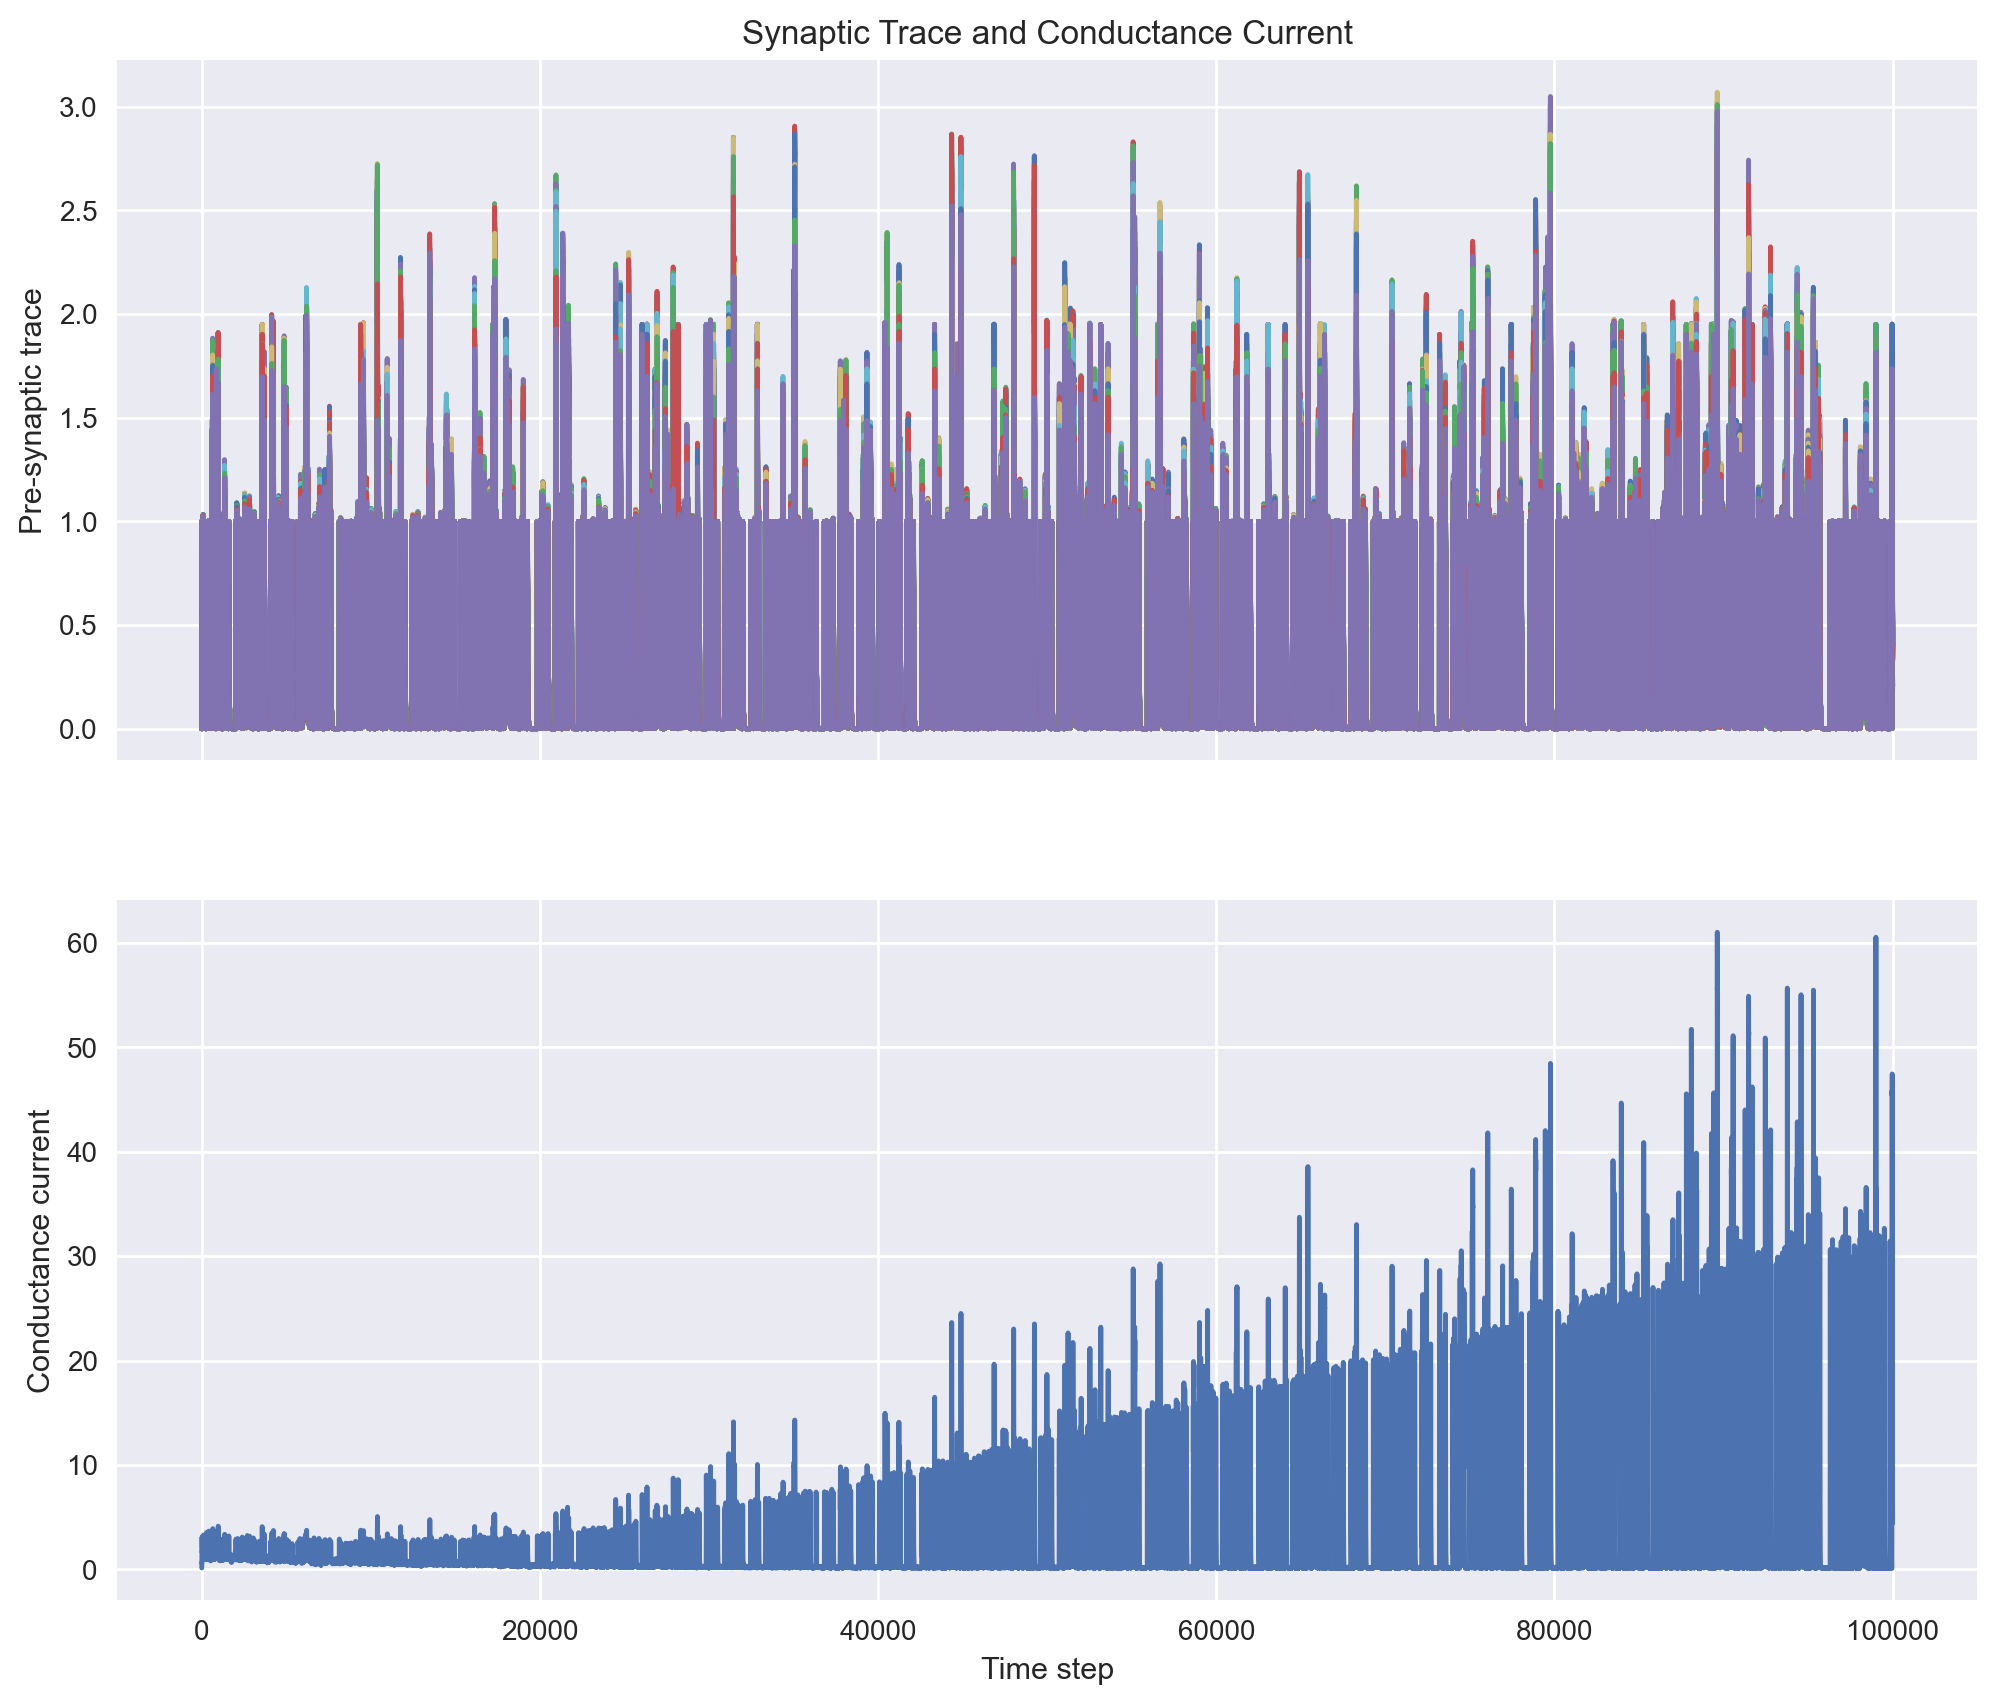

In [ ]:
# plo tcorrelated synaptic traces
fig, ax = plt.subplots(2, figsize=(12,10), sharex=True, gridspec_kw = {'height_ratios': [ 1, 1]})
pre_syn_trace = my_synapses.get_records()['pre_trace'][:,:N_pre_correlated]

ax[0].plot(time_steps, pre_syn_trace)
ax[0].set_ylabel("Pre-synaptic trace")
ax[0].set_title("Synaptic Trace and Conductance Current")

ax[1].plot(time_steps, cond_record[1:,:N_pre_correlated])
ax[1].set_ylabel("Conductance current")
ax[1].set_xlabel("Time step")

plt.show()

# Simple SNN with 1FC layer

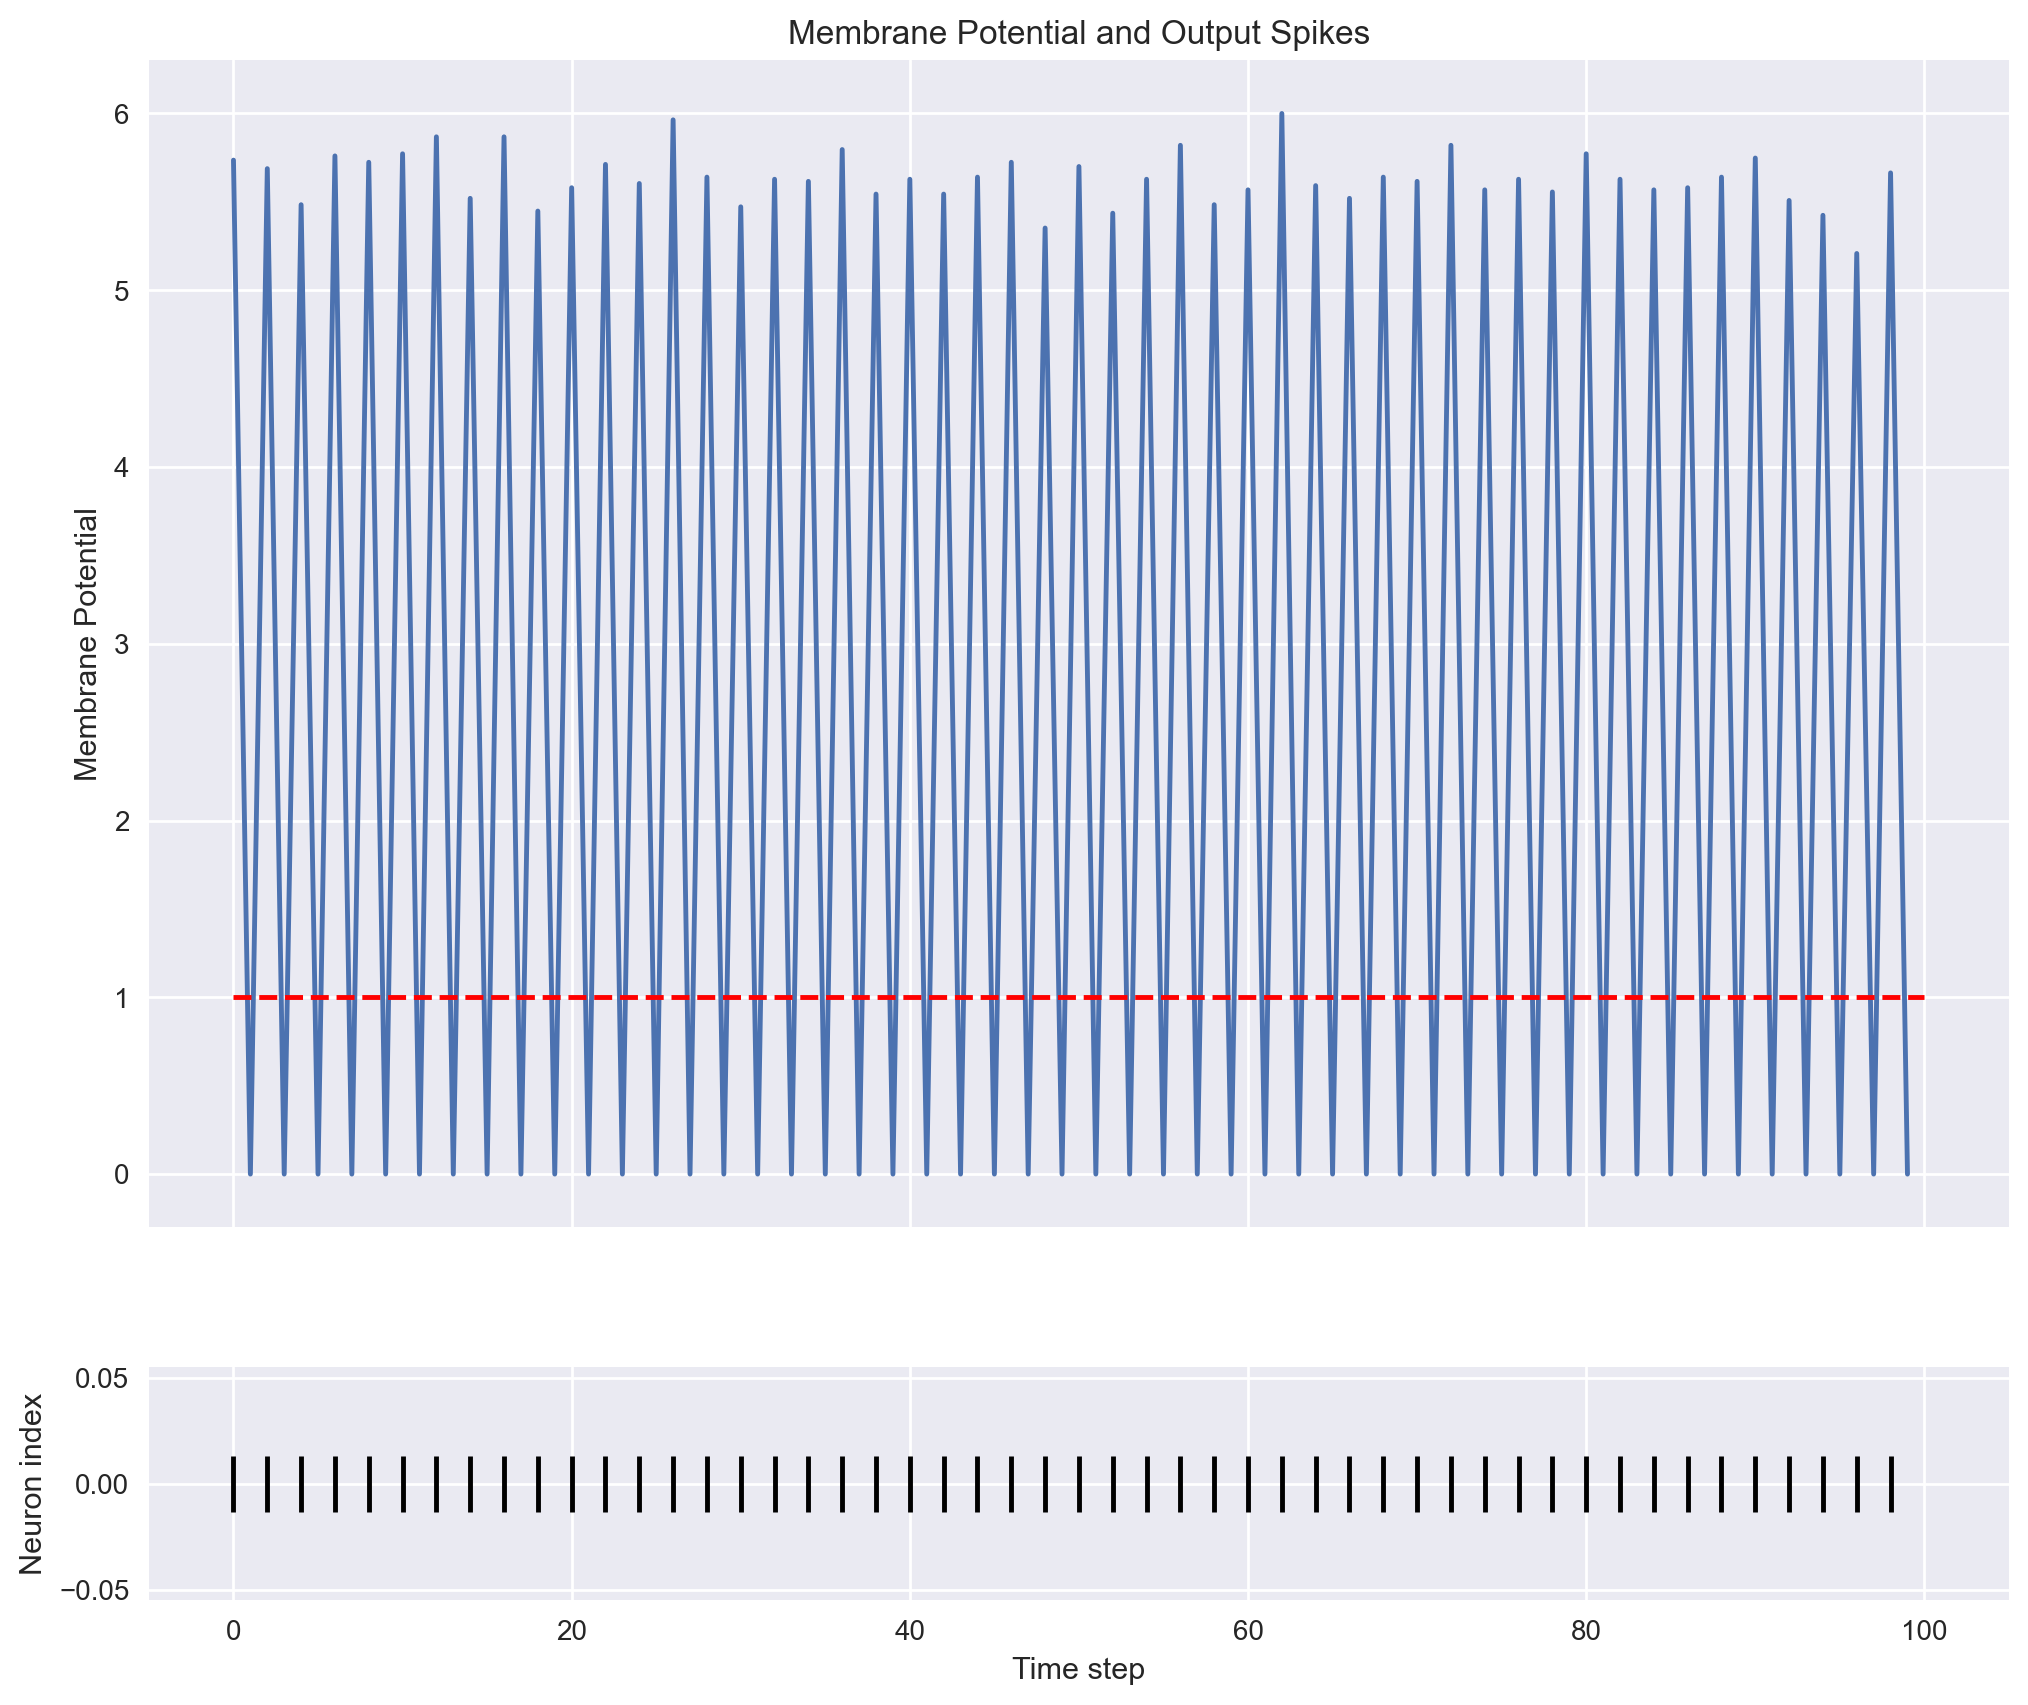

In [296]:
# basic variables
N_pre = 28*28
N_post = 1
batch_size = 2
num_steps = 100

class my_snn(nn.Module):

    def __init__(self, pars, N_pre, N_post = 1, batch_size = 32):
        super(my_snn, self).__init__()
        self.pars = pars
        self.alpha = pars.get('alpha', 0.9)
        self.beta = pars.get('beta', 0.8)
        self.fc = nn.Linear(N_pre, N_post, bias=False)
        # set the weight of the layer
        W_init = weight_initializer(pars, N_pre, N_post, type_init = 3, tensor = True)
        self.fc.weight = nn.Parameter(W_init)
        reset_mechanisc = 'zero' if pars['hard_reset'] else 'subtract'
        self.lif = snn.Leaky(beta = beta, threshold = pars['threshold'], reset_mechanism = reset_mechanisc)

    def forward(self, x):
        # initiliaze the membrane potential and the spike
        mem = self.lif.init_leaky()

        #tracking variables
        mem_rec = []
        spk_rec = []

        for step in range(x.shape[0]):
            cur_in = self.fc(x[step])
            spk, mem = self.lif(cur_in, mem)
            mem_rec.append(mem)
            spk_rec.append(spk)

        return torch.stack(mem_rec), torch.stack(spk_rec)
    



# parameters of the simulation
pars = default_pars(type_parameters='simple', 
                    w_init_value = 0.012,
                    alpha = 0.9,
                    beta = 0.8,
                    threshold = 1.0,
                    hard_reset = True)

# generate the input spikes
rate = 0.6
cur_in = Poisson_generator(pars['dt'], rate, N_pre, num_steps, batch_size = batch_size)
cur_in = torch.from_numpy(cur_in)
cur_in = cur_in.to(dtype = torch.float32, device = device)

# intitilize the model
my_model = my_snn(pars, N_pre, N_post)

# run the simulation
my_model.train()
mem_rec, spk_rec = my_model.forward(cur_in)

# plot the mem and spk
fig, ax = plt.subplots(2, figsize=(12,10), sharex=True, gridspec_kw = {'height_ratios': [1, 0.2]})
time_steps = np.arange(num_steps) * pars['dt']

# membrane potential
ax[0].plot(time_steps, mem_rec.detach().numpy()[:,0,:])
ax[0].hlines(pars['threshold'], 0, num_steps, color = 'red', linestyle = '--')
ax[0].set_ylabel("Membrane Potential")
ax[0].set_title("Membrane Potential and Output Spikes")

# output spikes
splt.raster(spk_rec[:,0,:], s = 400, ax = ax[1],  c="black", marker="|")
ax[1].set_ylabel("Neuron index")
ax[1].set_xlabel("Time step")

plt.show()